<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

Import libraries for deep learning and neural network models:
- **Keras/TensorFlow**: For building neural networks (Sequential, Dense, LSTM layers)
- **scikeras**: Wrapper to use Keras models with scikit-learn API
- **sklearn**: For preprocessing, metrics, and evaluation
- **seaborn**: For enhanced visualizations

In [ ]:
!pip install -U scikeras

**Install scikeras**: This package provides a scikit-learn compatible wrapper for Keras models, allowing us to use neural networks in scikit-learn pipelines and with familiar APIs.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Flatten, Dense, LSTM
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns


## Read OHLC, Features, and Target

**Load Features**: Read the engineered features that will be used as input to the neural network models.


In [ ]:
Ohlc = pd.read_parquet( root / '1. ohlc.parquet' )

Features = pd.read_parquet( root / '2. features.parquet' )
Features.head()

,ema(30),"x(sma(15),sma(50))","bollUpper(20,2)","bollLower(20,2)","macdDistance(12, 26, 9)",rsiEma(14),mfi(14),atr(14),realized_vol(14),vol_ratio,...,return_1d,return_3d,return_5d,return_10d,momentum_5d,momentum_10d,momentum_20d,price_position(20),dist_from_high(20),dist_from_low(20)
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-22,82604.411908,1.0,104231.402465,64963.117535,971.784014,85.764364,88.450118,4209.416429,0.537691,1.407752,...,0.005004,0.072055,0.101861,0.125539,0.101861,0.125539,0.428759,1.000000,0.000000,0.459895
2024-11-23,83589.934731,1.0,105029.743415,67068.392585,800.507075,78.388066,84.555442,4253.902857,0.550372,1.424490,...,-0.012327,0.036441,0.079903,0.079408,0.079903,0.079408,0.422399,0.960868,-0.012327,0.441898
2024-11-24,84526.399811,1.0,105188.115929,69930.251071,610.002580,78.795923,79.477909,4107.482143,0.535772,1.372835,...,0.002419,-0.004984,0.061401,0.123362,0.061401,0.123362,0.445386,0.966805,-0.009938,0.413126
2024-11-25,85082.959416,1.0,104289.235204,73203.405796,88.327747,54.261891,71.404118,3891.115714,0.433320,1.104937,...,-0.050110,-0.059550,-0.013114,0.022361,-0.013114,0.022361,0.342314,0.747615,-0.059550,0.230876
2024-11-26,85530.738448,1.0,103874.811967,75252.453033,-372.215541,50.163352,61.819462,3849.627857,0.435544,1.103329,...,-0.011997,-0.059236,-0.066184,0.015756,-0.066184,0.015756,0.216108,0.696341,-0.070833,0.211850


**Load Target**: Read the 3-class target variable (Down, Stationary, Up) and convert to Series format.


**Data Check**: Verify data dimensions and check for missing values. Also examine target class distribution to understand class balance.


In [ ]:
Target = pd.read_parquet( root / '2. target.parquet' )
Target = Target.squeeze()
Target.head()

,Target
Date,
2024-11-22,0
2024-11-23,1
2024-11-24,0
2024-11-25,0
2024-11-26,2


In [ ]:
print( len(Features), len(Target) )
print( Features.isnull().sum().sum(), Target.isnull().sum() )

Target.value_counts()

292 292
0 0


,count
Target,
1,133
2,80
0,79


## Train Test Split

**Sequence Creation and Scaling**:

1. **create_sequences()**: Converts time series into sequences of length `window` (50 timesteps). Each sequence uses the past 50 days to predict the next day's class.

2. **Proper Scaling Order**:
   - **Step 1**: Create sequences first (no scaling yet)
   - **Step 2**: Split into train/test
   - **Step 3**: Fit scaler ONLY on training data
   - **Step 4**: Transform both train and test using the training-fitted scaler
   
   This ensures no future statistics leak into past predictions.

3. **One-Hot Encoding**: Convert 3-class targets (0, 1, 2) to one-hot format `[1,0,0]`, `[0,1,0]`, `[0,0,1]` required by neural networks with categorical crossentropy loss.

**Shape Check**: Verify the sequence dimensions are correct: `(samples, timesteps, features)`


In [ ]:
def create_sequences(X, y, window):
  Xs, ys = [], []
  for i in range(len(X) - window):
    Xs.append( X[ i:(i+window) ] )
    ys.append( y[ i+window ] )
  return np.array(Xs), np.array(ys)

train_size_ratio = 0.8
window           = 50

# Step 1: Create sequences
X_seq, y_seq = create_sequences( Features.values, Target.values, window )
train_size = int( len(X_seq) * train_size_ratio )
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Step 2: Scale
scaler = StandardScaler()
# Reshape for scaling: (samples, timesteps, features) -> (samples * timesteps, features)
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled  = scaler.transform(X_test_reshaped).reshape(X_test.shape)

X_train, X_test = X_train_scaled, X_test_scaled

# Step 3: Convert targets to one-hot encoding for 3-class classification
from keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)



In [ ]:
# check multivariate timeseries shape
X_train.shape, y_train.shape

((193, 50, 25), (193,))

## Plot Utilities

In [ ]:
def plotConfusionMatrix(y_test, y_pred, class_names=['Down', 'Stationary', 'Up']):
  """ Plot confusion matrix for 3-class classification """
  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(1, 1, figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names,
              ax=ax, cbar_kws={'label': 'Count'})
  ax.set_xlabel('Predicted', fontsize=12)
  ax.set_ylabel('Actual', fontsize=12)
  ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
  plt.tight_layout()
  plt.show()

  return cm


def printClassificationReport(y_test, y_pred, class_names=['Down', 'Stationary', 'Up']):
  """ Print detailed classification report """
  print("\n" + "="*60)
  print("CLASSIFICATION REPORT")
  print("="*60)
  print(classification_report(y_test, y_pred, target_names=class_names))
  print("="*60 + "\n")


def plotMultiClassROC(y_test, y_pred_proba, class_names=['Down', 'Stationary', 'Up']):
  """ Plot multi-class ROC curves (one-vs-rest) """
  n_classes = len(class_names)

  # Binarize the output for multi-class ROC
  y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot all ROC curves
  fig, ax = plt.subplots(1, 1, figsize=(12, 10))

  colors = ['blue', 'red', 'green', 'orange']
  for i, color in zip(range(n_classes), colors[:n_classes]):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

  # Plot micro-average ROC curve
  ax.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
          label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

  ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate', fontsize=12)
  ax.set_ylabel('True Positive Rate', fontsize=12)
  ax.set_title('Multi-Class ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
  ax.legend(loc="lower right", fontsize=10)
  ax.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  return roc_auc


def plotPredVsTrue( y_test, y_pred, raw, rawCol ):
  """ plot predictions vs. true values """

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

  xindex = raw.index[-len(y_test):]
  top = {
      'y_test': y_test,
      'y_pred': y_pred,
  }
  bottom = {
      rawCol : raw.loc[ xindex ],
  }

  for label, vals in top.items():
    ax1.plot( xindex, vals, label=label )

  for label, vals in bottom.items():
    ax2.plot( vals )

  for ax in [ax1, ax2]:
    ax.legend()
    ax.grid(True)

  plt.show()


## Simple Neural Network

**Simple Neural Network (Feedforward)**:

Architecture:
- **Flatten**: Converts 3D sequences `(samples, timesteps, features)` to 2D `(samples, timesteps*features)`
- **Dense Layers**: Fully connected layers with decreasing size (16 → 8 → 4)
- **Output**: 3 neurons with softmax activation (probabilities for 3 classes)
- **Loss**: Categorical crossentropy (standard for multi-class classification)

**Training**: Uses KerasClassifier wrapper to train with scikit-learn-like interface. After training, predictions are converted from probabilities to class labels using `argmax`.

**Evaluation**: The model outputs include:
- Classification report with precision/recall per class
- Confusion matrix visualization
- ROC curves for each class
- Time series plot of predictions vs actual


/usr/local/lib/python3.12/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4288 - loss: 1.0967
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4917 - loss: 1.0120
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5291 - loss: 0.9136
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5577 - loss: 0.9039
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5627 - loss: 0.8917
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6313 - loss: 0.8055
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6249 - loss: 0.8346
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6092 - loss: 0.8127
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6397 - loss: 0.7365
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6612 - loss: 0.7328
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6867 - loss: 0.6863
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

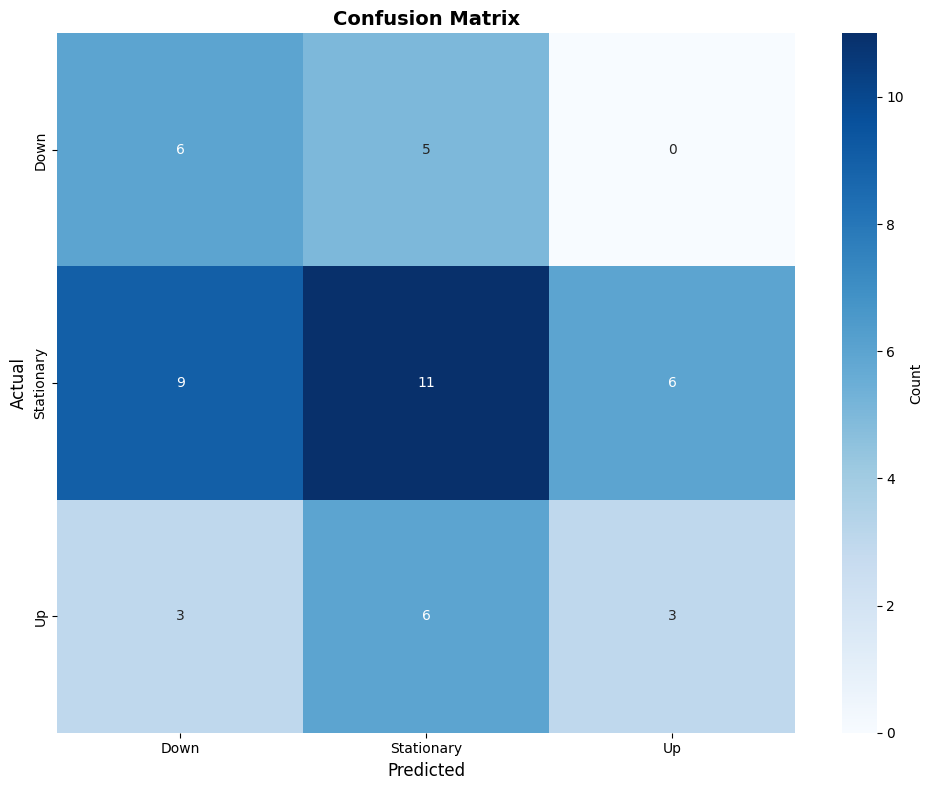

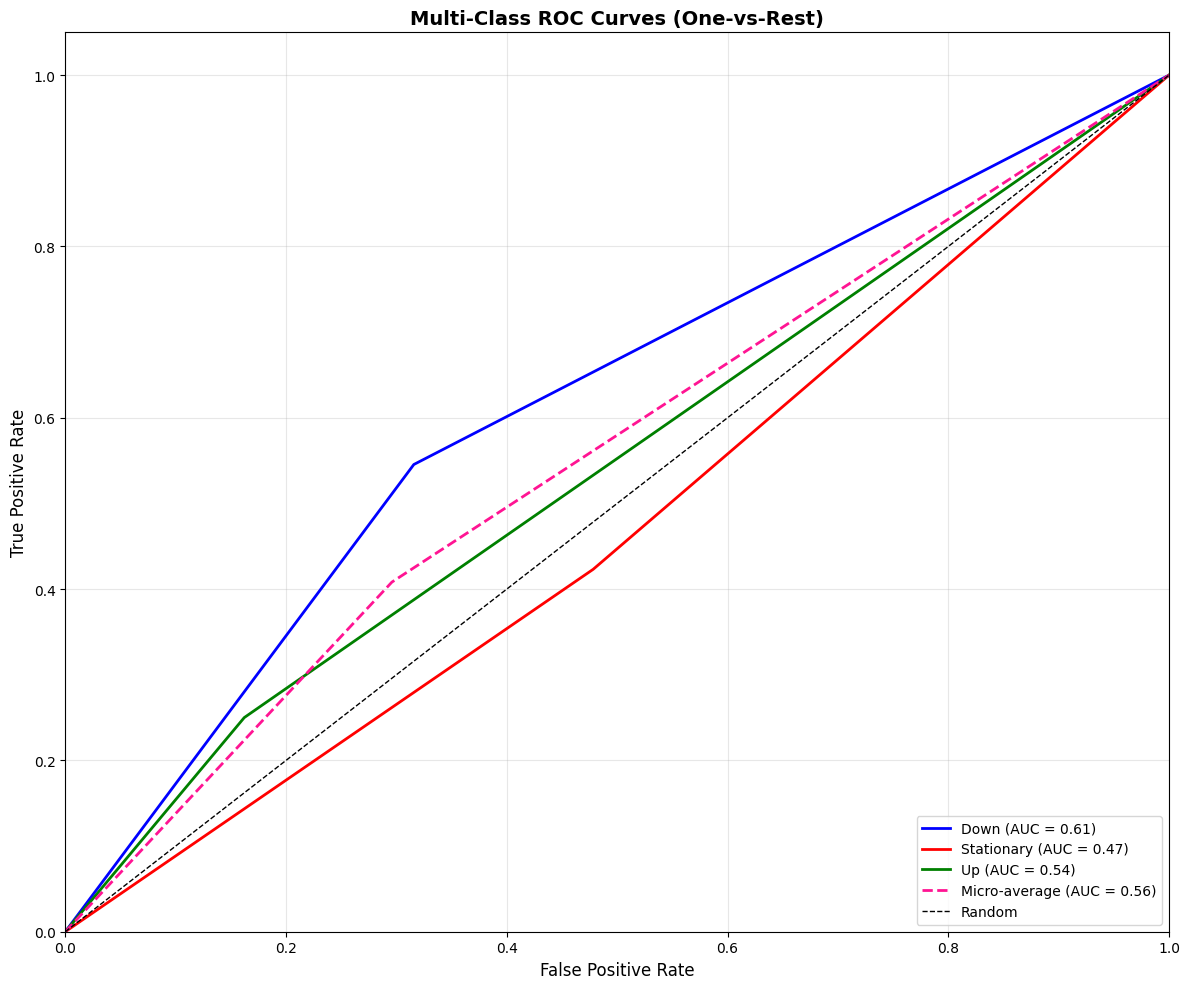

/tmp/ipython-input-3185168852.py:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


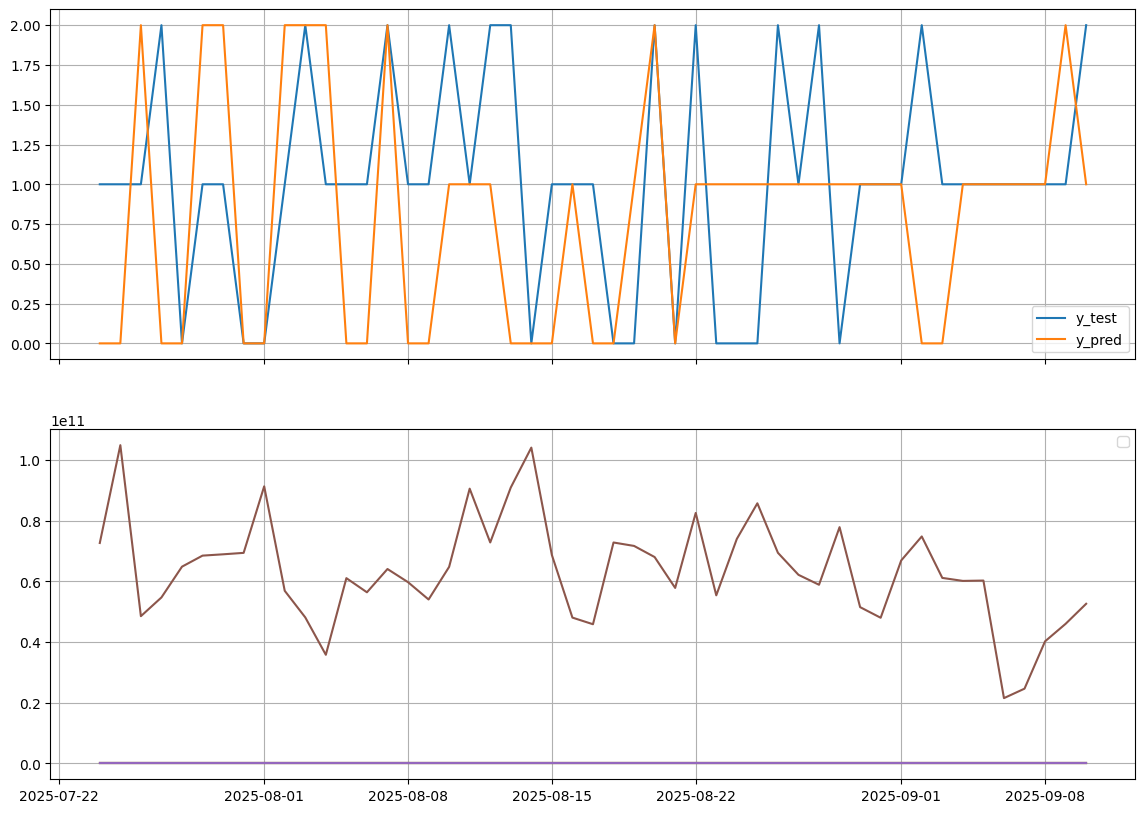

In [ ]:
def make_build_fun( input_shape ):
  def build_fn():
    model = Sequential()
    model.add( Flatten(input_shape=input_shape ))
    model.add( Dense(16, activation='tanh' ))
    model.add( Dense(8, activation='relu' ))
    model.add( Dense(4, activation='relu' ))
    model.add( Dense(3, activation='softmax' ))  # UPDATED: 3 classes (Down, Stationary, Up)

    model.compile(
        optimizer = 'adam',
        loss      = 'categorical_crossentropy',
        metrics   = ['accuracy'],
    )
    return model

  return build_fn


build_fn = make_build_fun( X_train.shape[1:] )

clf = KerasClassifier( build_fn=build_fn, epochs=100, batch_size=10, verbose=1 )
clf.fit( X_train, y_train_onehot )  # UPDATED: Use one-hot encoded targets
y_pred_proba = clf.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert from one-hot to class labels

# UPDATED: Use multi-class evaluation metrics
printClassificationReport(y_test, y_pred)
plotConfusionMatrix(y_test, y_pred)
plotMultiClassROC(y_test, y_pred_proba)
plotPredVsTrue(  y_test, y_pred, Ohlc, 'Close' )



## LSTM

**LSTM (Long Short-Term Memory) Network**:

LSTM is designed for sequence data and can learn long-term dependencies:
- **LSTM Layer (32 units)**: Processes the sequence of 50 timesteps, maintaining memory across time
- **Dense Layers**: Additional processing layers (16 → 8 units)
- **Output**: 3-class softmax output

**Key Difference from Simple NN**: LSTM preserves temporal information and can learn patterns that span multiple timesteps, whereas the simple network flattens time dimension and loses temporal structure.

**Training**: Similar to simple network but may take longer due to LSTM's complexity. Monitor training loss to check for overfitting.


/usr/local/lib/python3.12/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3018 - loss: 1.1486
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4287 - loss: 1.0786
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4848 - loss: 1.0547
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5763 - loss: 1.0389
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5167 - loss: 1.0435
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4698 - loss: 1.0444
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4932 - loss: 1.0332
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6274 - loss: 0.9704
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5233 - loss: 1.0137
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5439 - loss: 0.9727
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6292 - loss: 0.9375
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


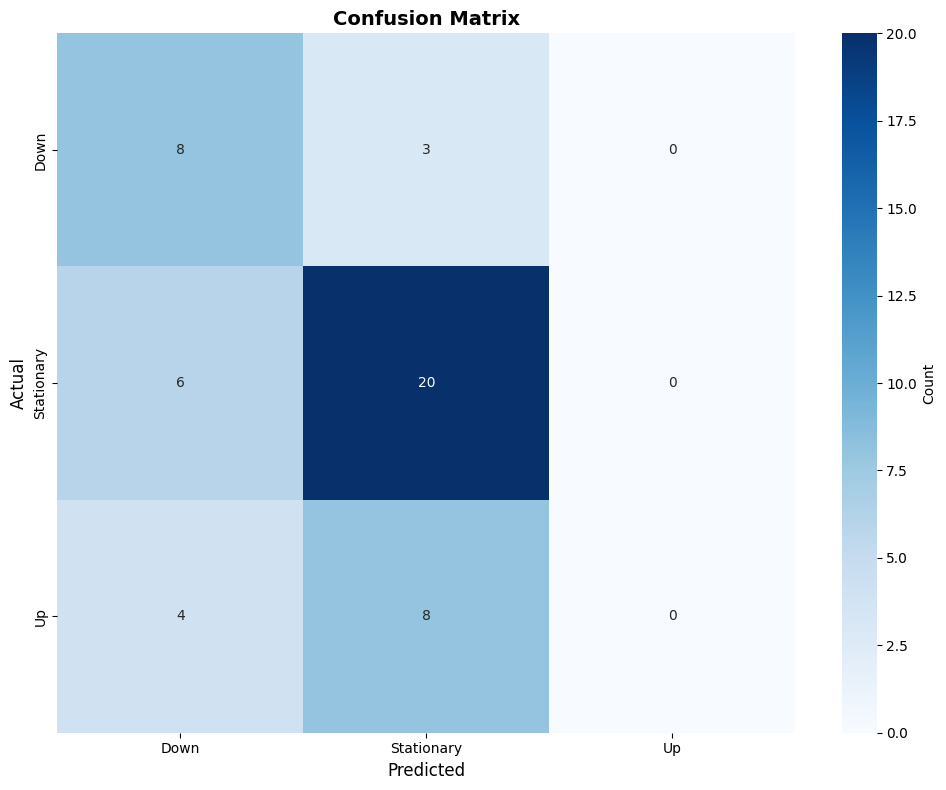

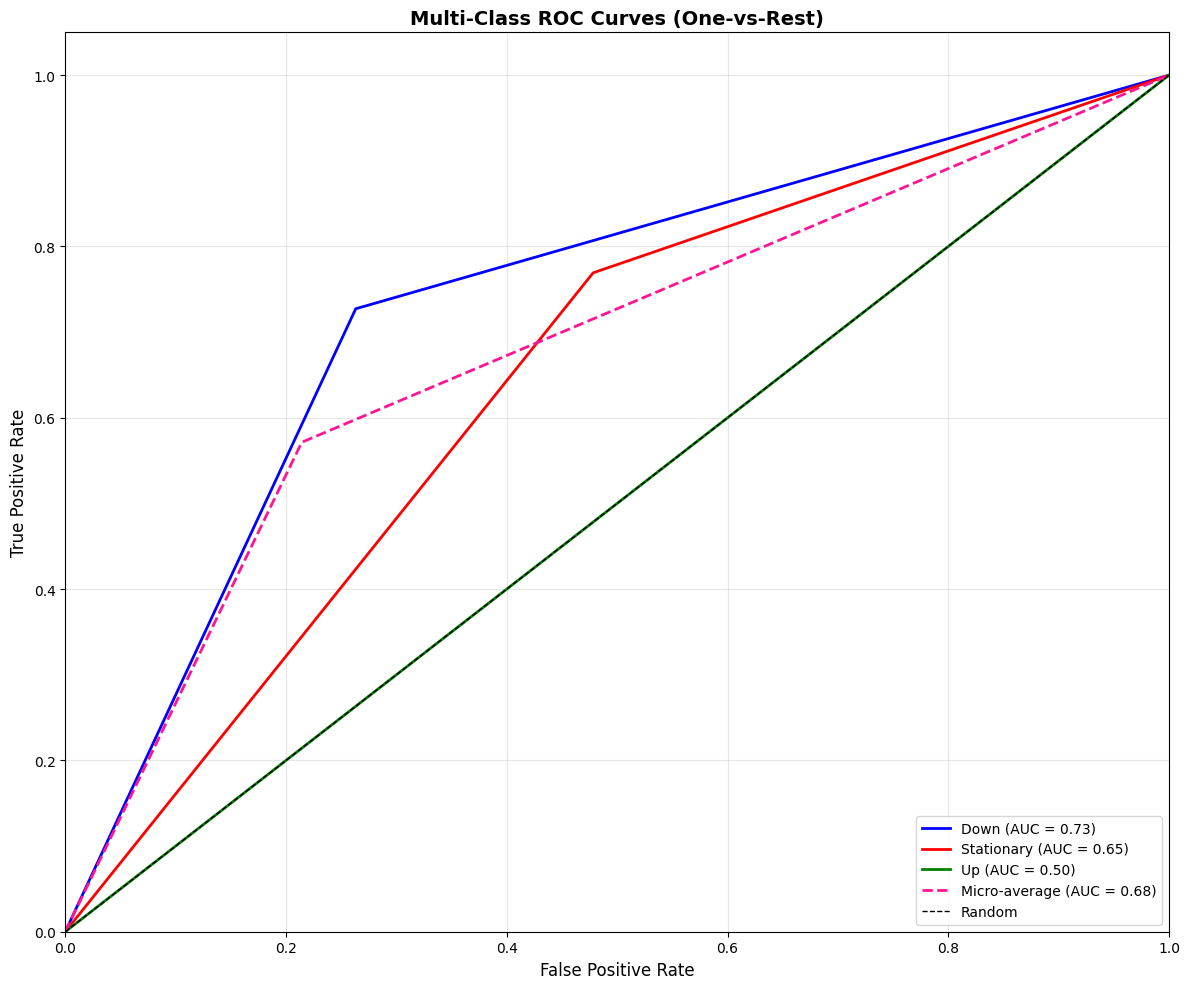

/tmp/ipython-input-3185168852.py:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


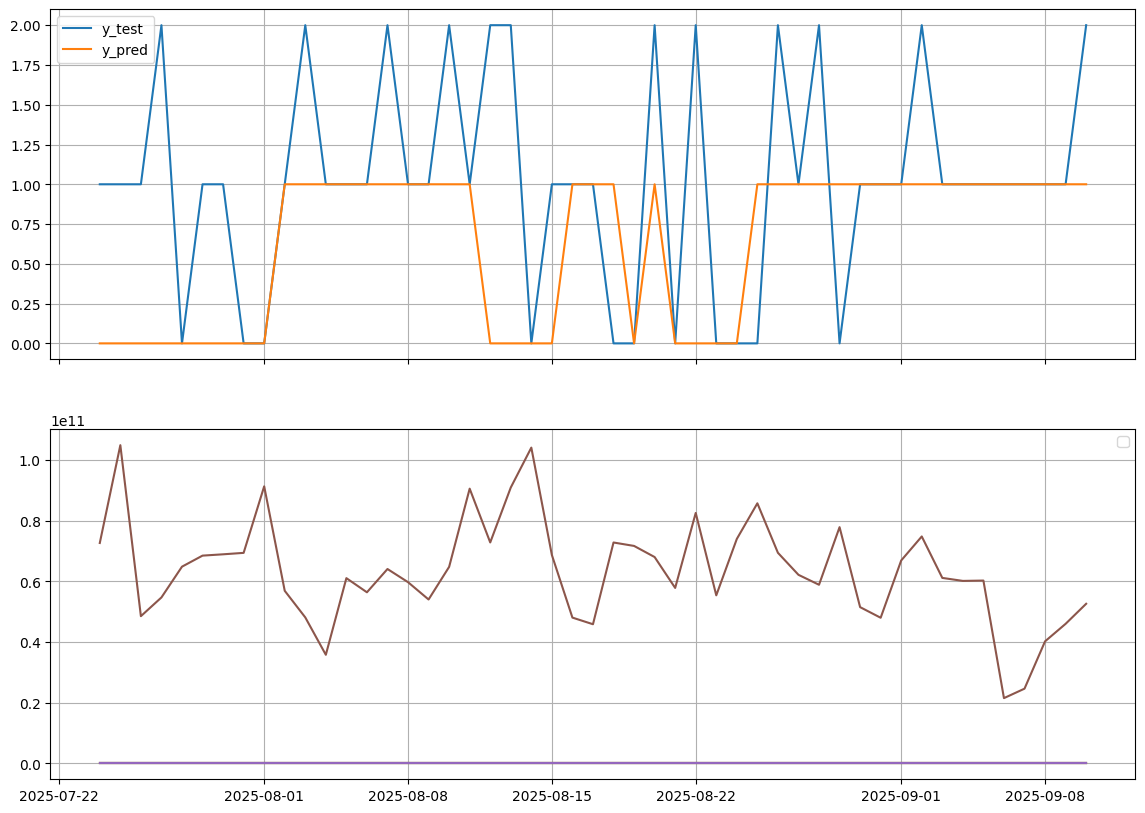

In [ ]:
def make_build_fn( input_shape ):
  """ closure to make function """

  def build_fn():
    """ build function """

    model = Sequential()
    model.add( LSTM( 32, activation='tanh', input_shape=input_shape ))
    model.add( Dense( 16, activation='relu' ))
    model.add( Dense( 8, activation='relu' ))
    model.add( Dense( 3, activation='softmax' ))  # UPDATED: 3 classes (Down, Stationary, Up)

    model.compile(
        optimizer = 'adam',
        loss      = 'categorical_crossentropy',
        metrics   = ['accuracy'],
    )
    return model

  return build_fn


build_fn = make_build_fn( X_train.shape[1:] )

clf = KerasClassifier( build_fn=build_fn, epochs=100, batch_size=10, verbose=1 )
clf.fit( X_train, y_train_onehot )  # UPDATED: Use one-hot encoded targets
y_pred_proba = clf.predict( X_test )
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert from one-hot to class labels

# UPDATED: Use multi-class evaluation metrics
printClassificationReport(y_test, y_pred)
plotConfusionMatrix(y_test, y_pred)
plotMultiClassROC(y_test, y_pred_proba)
plotPredVsTrue(  y_test, y_pred, Ohlc, 'Close' )

## Conclusions

1. **Predicting price direction is inherently difficult.** Markets are noisy and influenced by external factors not captured in price history. Achieving accuracy above 60% requires careful feature engineering and proper data handling.

2. **Proper time series validation is essential.** Time-aware splitting prevents data leakage and provides realistic performance estimates. Both simple feedforward and LSTM models showed similar performance, indicating data preprocessing matters more than architecture for this dataset size.

3. **Model architecture alone is insufficient.** The choice between feedforward networks and LSTMs showed that avoiding data leakage through proper scaling and sequence creation is more impactful than architectural complexity.

4. **Even moderate edges can be meaningful.** A model with 55-60% directional accuracy, combined with proper position sizing and risk management, can yield positive expected returns despite modest classification performance.

## Future Exploration

1. **Create reusable time-aware validation utilities** for consistent cross-validation across models and datasets.

2. **Test models across different market regimes** (bull, bear, consolidation) to identify when models generalize and when they fail.

3. **Implement regime detection and adaptive retraining** to automatically detect market regime changes and adapt models accordingly.

4. **Explore additional features** such as volatility measures (ATR), volume-price relationships (OBV, VWAP), and lag features to improve signal extraction.

5. **Investigate ensemble methods** combining predictions from multiple models (Logistic Regression, Random Forest, Neural Networks) for improved robustness.

6. **Expand dataset or use transfer learning** to address the limited sample size (292 samples), potentially using data from similar assets.

7. **Implement proper backtesting framework** with transaction costs, position sizing, risk management, and metrics like Sharpe ratio and maximum drawdown.
